# Clustering and NLP-based labelling of extracted and cleaned BHRRC company responses


In [30]:
# Libraries
from pathlib import Path
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import os, re, math
import json


# CONFIG
ROOT_DIR = "C:/Users/bscherrer/Documents/snf-project3"
INPUT_PATH = Path(os.path.join(ROOT_DIR, 'data', 'narratives.json'))
OUTPUT_CSV = Path(os.path.join(ROOT_DIR, 'data', 'clusters.csv'))
OUTPUT_LABELS = Path(os.path.join(ROOT_DIR, 'data', 'cluster_labels.json'))

EMBED_MODEL = "text-embedding-3-small"
CHAT_MODEL = "gpt-5-mini"
BATCH_SIZE = 128
SEED = 42

# -----------------------------
# Init OpenAI (reads OPENAI_API_KEY from .env)
# -----------------------------
load_dotenv()
client = OpenAI()

# Read in data
def load_items(json_path: Path) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    rows = []
    for doc in data:
        doc_id = doc.get("document_id")
        items = doc.get("items", []) or []
        for i, txt in enumerate(items):
            if txt and str(txt).strip():
                rows.append({
                    "document_id": doc_id,
                    "row_id": f"{doc_id}-{i}",
                    "text": str(txt).strip()
                })

    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("No items found to cluster in the provided JSON.")
    # Drop duplicates by text to avoid over-weighting boilerplate
    df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
    return df


df = load_items(INPUT_PATH)
df.head(5)


,document_id,row_id,text
0,doc_0000,doc_0000-0,We wish to state categorically that there was ...
1,doc_0000,doc_0000-1,The security staff employed by the Corrib Gas ...
2,doc_0000,doc_0000-2,Almost six weeks after making these allegation...
3,doc_0000,doc_0000-3,[also includes security log of the events]
4,doc_0001,doc_0001-0,The report makes assumptions about investment ...


## 3) Create embeddings

Two options:
1. **Sentence-Transformers** (default, local): e.g., `all-MiniLM-L6-v2` (fast) or `all-mpnet-base-v2` (higher quality).
2. **OpenAI embeddings** (optional): requires API key; can be helpful if you already use their stack.

We'll implement Sentence-Transformers first, with a toggle to switch.


In [31]:
from utils.embedder import DocumentEmbedder
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# === Embeddings (Sentence-Transformers by default) ===
EMBED_MODEL = "all-mpnet-base-v2"  # or 'all-mpnet-base-v2'

# Embed the framing field
embedder = DocumentEmbedder(
    model_name=EMBED_MODEL,
    pooling=None,
    batch_size=32,
    target_devices=['cpu'] * 4
)

docs = [[d] for d in df.text]

doc_embeddings = embedder.encode_documents(docs, pool_embeddings=False)

# unpack the nested embeddings and add to dataframe
df['embedding_framing'] = [d[0] for d in doc_embeddings]


Chunks: 100%|██████████| 40/40 [04:35<00:00,  6.88s/it]


# Clustering

In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from umap.umap_ import UMAP
import numpy as np

X = np.vstack(df['embedding_framing'].values)


# def choose_k_agglom(X: np.ndarray, k_min: int = 4, k_max: int = 20) -> int:
#     k_max = min(k_max, max(k_min, X.shape[0] - 1))
#     best_k, best_score = None, -1
#     for k in range(k_min, max(k_min, k_max) + 1):
#         try:
#             model = AgglomerativeClustering(
#                 n_clusters=k,
#                 metric="cosine",
#                 linkage="average"
#             )
#             labels = model.fit_predict(X)
#             score = silhouette_score(X, labels, metric="cosine")
#             if score > best_score:
#                 best_k, best_score = k, score
#         except Exception:
#             pass
#     return best_k or 10

# agglomerative clustering
def cluster_texts_agglomerative(df: pd.DataFrame) -> pd.DataFrame:
    texts = df["text"].tolist()
    k = 30

    model = AgglomerativeClustering(
        n_clusters=k,
        metric="cosine",
        linkage="average"
    )
    labels = model.fit_predict(X)
    df["cluster"] = labels
    df["cluster_labels"] = model.labels_.astype(str)


    # reduce to 3 dimensions for 3D plotting
    umap_3d = UMAP(n_components=3, random_state=42)
    X_3d = umap_3d.fit_transform(X)
    df["umap_x"] = X_3d[:,0]
    df["umap_y"] = X_3d[:,1]
    df["umap_z"] = X_3d[:,2]

    print(f"Chosen k = {k}. Cluster sizes:", df["cluster"].value_counts().sort_index().to_dict())
    return df

df = cluster_texts_agglomerative(df)
df.head(5)

c:\Users\bscherrer\AppData\Local\miniconda3\envs\scrape-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Chosen k = 30. Cluster sizes: {0: 61, 1: 2109, 2: 31, 3: 35, 4: 132, 5: 2, 6: 300, 7: 6, 8: 24, 9: 5, 10: 26, 11: 10, 12: 11, 13: 26, 14: 326, 15: 3, 16: 1, 17: 6, 18: 8, 19: 1, 20: 23, 21: 4, 22: 11, 23: 4, 24: 2, 25: 1, 26: 5, 27: 3, 28: 2, 29: 13}


,document_id,row_id,text,embedding_framing,cluster,cluster_labels,umap_x,umap_y,umap_z
0,doc_0000,doc_0000-0,We wish to state categorically that there was ...,"[-0.0044859694, 0.05912423, 0.013661704, 0.090...",0,0,15.219341,6.899935,6.600753
1,doc_0000,doc_0000-1,The security staff employed by the Corrib Gas ...,"[0.0072000716, -0.03199109, 0.013125419, 0.018...",1,1,17.303911,7.292752,9.374906
2,doc_0000,doc_0000-2,Almost six weeks after making these allegation...,"[0.030226259, 0.053812157, 0.00989175, 0.04500...",0,0,15.164168,6.964921,6.593819
3,doc_0000,doc_0000-3,[also includes security log of the events],"[-0.018522447, 0.020260014, 0.016050152, 0.070...",0,0,16.490881,6.648694,7.801798
4,doc_0001,doc_0001-0,The report makes assumptions about investment ...,"[0.022115024, 0.028229032, 0.0037889022, 0.001...",6,6,13.535350,5.110564,9.923628


# Plot the clusters

In [33]:
import plotly.express as px
fig = px.scatter_3d(
    df,
    x='umap_x',
    y='umap_y',
    z='umap_z',
    color = 'cluster_labels',
    hover_data={'cluster_labels': True},           # show text on hover
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=2, opacity=0.8))
fig.show()

## 6) NLP-based Labelling
reads a prompt from utils and uses it together with an LLM to label the clusters (2-3 words per label)


In [34]:
# -----------------------------
# LLM cluster labeling (same as before)
# -----------------------------
from utils.prompts import labelling_prompt2
from typing import List, Dict
import time
import random


def label_one_cluster(cid: int, examples: List[str], model: str = CHAT_MODEL) -> Dict:
    samp = examples[:8]  # cap to keep prompt small
    user_content = (
        f"Cluster {cid}\n"
        f"Examples:\n- " + "\n- ".join(samp) +
        "\n\nReturn JSON with keys: cluster_id, label, rationale, rq (list of ints 1..6)."
    )
    resp = client.chat.completions.create(
        model=model,
        temperature=1,
        messages=[
            {"role": "system", "content": labelling_prompt2},
            {"role": "user", "content": user_content},
        ],
    )
    txt = resp.choices[0].message.content.strip()
    try:
        return json.loads(txt)
    except Exception:
        return {
            "cluster_id": cid,
            "label": txt[:60],
            "rationale": "free-text label (fallback)",
            "rq": []
        }

def label_clusters(df: pd.DataFrame, per_cluster_examples: int = 8) -> Dict[int, Dict]:
    labels = {}
    for cid, sub in df.groupby("cluster"):
        exs = sub["text"].tolist()
        random.Random(SEED).shuffle(exs)
        exs = exs[:per_cluster_examples]
        labels[cid] = label_one_cluster(cid, exs)
        time.sleep(0.2)
    return labels


labels = label_clusters(df, per_cluster_examples=8)
df["cluster_label"] = df["cluster"].map({cid: info.get("label") for cid, info in labels.items()})
df["cluster_rq"] = df["cluster"].map({cid: info.get("rq") for cid, info in labels.items()})

df[["document_id", "text", "cluster", "cluster_label", "cluster_rq"]].to_csv(OUTPUT_CSV, index=False)
with open(OUTPUT_LABELS, "w", encoding="utf-8") as f:
    json.dump(labels, f, ensure_ascii=False, indent=2)

print(f"Wrote {OUTPUT_CSV.resolve()} and {OUTPUT_LABELS.resolve()}")

Wrote C:\Users\bscherrer\Documents\snf-project3\data\clusters.csv and C:\Users\bscherrer\Documents\snf-project3\data\cluster_labels.json


# Visualization & exports

## merge data


In [42]:
import os
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

CLUSTERS_PTH = Path(os.path.join(ROOT_DIR, 'data', 'clusters.csv'))
META_PTH     = Path(os.path.join(ROOT_DIR, 'data', "prepared_df.csv"))  # attached CSV with company metadata
OUTPUT_MERGED   = Path(os.path.join(ROOT_DIR,'data',"merged.csv"))
PLOTS_DIR    = Path(os.path.join(ROOT_DIR,"plots"))
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# read data
df_clusters = pd.read_csv(CLUSTERS_PTH)
required = {"document_id", "cluster_label"}
missing = required - set(df_clusters.columns)
if missing:
    raise ValueError(f"clusters.csv missing columns: {missing}. Found: {list(df_clusters.columns)}")

df_meta = pd.read_csv(META_PTH)
if "doc_id" not in df_meta.columns:
    raise ValueError("prepared_df.csv must contain 'doc_id' to join with clusters.")
df_meta = df_meta.rename(columns={"doc_id": "document_id"})

# Date parsing
if "date" in df_meta.columns:
    df_meta["date_parsed"] = pd.to_datetime(df_meta["date"], errors="coerce", utc=True)
elif "Backdate" in df_meta.columns:
    df_meta["date_parsed"] = pd.to_datetime(df_meta["Backdate"], errors="coerce", utc=True, dayfirst=True)
else:
    df_meta["date_parsed"] = pd.NaT
    warnings.warn("No 'date' or 'Backdate' column found; time-based plots may be empty.")

df = df_clusters.merge(df_meta, on="document_id", how="left")

# Normalize labels
df["cluster_label"] = df["cluster_label"].fillna("Unlabeled").replace({"": "Unlabeled"})
# Derive monthly period for time plots
df["month"] = df["date_parsed"].dt.to_period("M")
# Save merged
df.to_csv(OUTPUT_MERGED, index=False)
print(f"Saved merged file: {OUTPUT_MERGED.resolve()} (rows={len(df)})")




C:\Users\bscherrer\AppData\Local\Temp\ipykernel_25872\3333383064.py:42: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Saved merged file: C:\Users\bscherrer\Documents\snf-project3\data\merged.csv (rows=3191)


## Plot by sector

Saved: C:\Users\bscherrer\Documents\snf-project3\plots\labels_by_sector.png


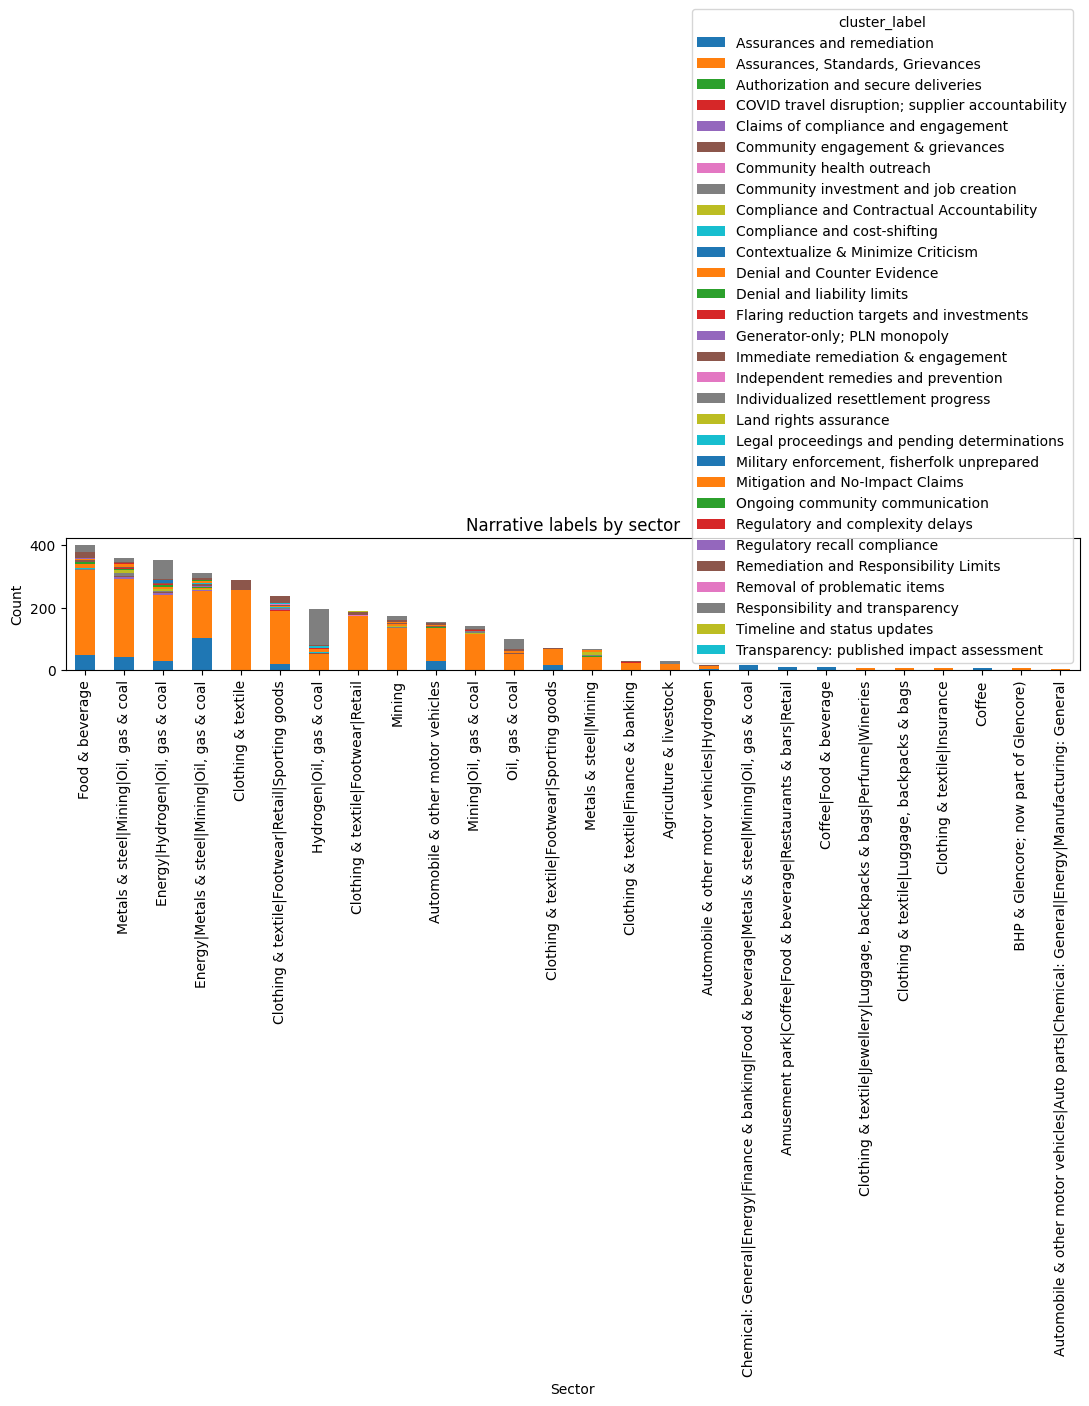

In [36]:
by_sector = (
    df.groupby(["Company Sectors", "cluster_label"])
      .size()
      .reset_index(name="n")
)
pivot_sector = by_sector.pivot(index="Company Sectors", columns="cluster_label", values="n").fillna(0)

# Order sectors by total volume
pivot_sector = pivot_sector.loc[pivot_sector.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(11, max(4, 0.35 * len(pivot_sector))))
pivot_sector.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Narrative labels by sector")
plt.xlabel("Sector")
plt.ylabel("Count")
plt.tight_layout()
out1 = PLOTS_DIR / "labels_by_sector.png"
plt.savefig(out1, dpi=150)
print(f"Saved: {out1.resolve()}")
plt.show()
plt.close()

C:\Users\bscherrer\AppData\Local\Temp\ipykernel_25872\2377783481.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\bscherrer\AppData\Local\Temp\ipykernel_25872\2377783481.py:13: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



Saved: C:\Users\bscherrer\Documents\snf-project3\plots\labels_by_sector.png


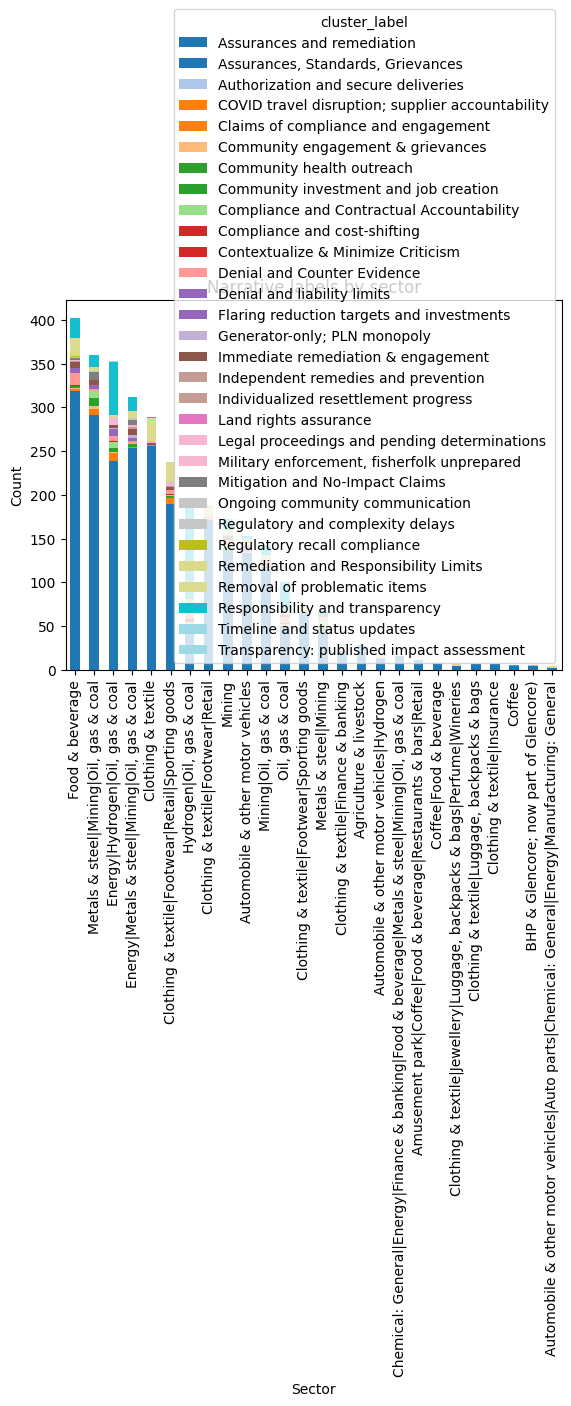

In [43]:
n_labels = len(labels)
cmap = cm.get_cmap('tab20', n_labels)  # or 'tab10', 'Set3', etc.

pivot_sector.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca(),
    color=[cmap(i) for i in range(n_labels)]
)
plt.title("Narrative labels by sector")
plt.xlabel("Sector")
plt.ylabel("Count")
plt.tight_layout()
out1 = PLOTS_DIR / "labels_by_sector.png"
plt.savefig(out1, dpi=150)
print(f"Saved: {out1.resolve()}")
plt.show()
plt.close()

# Top 15 labels

C:\Users\bscherrer\AppData\Local\Temp\ipykernel_25872\3025333591.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Saved: C:\Users\bscherrer\Documents\snf-project3\plots\top_15_labels_by_sector.png


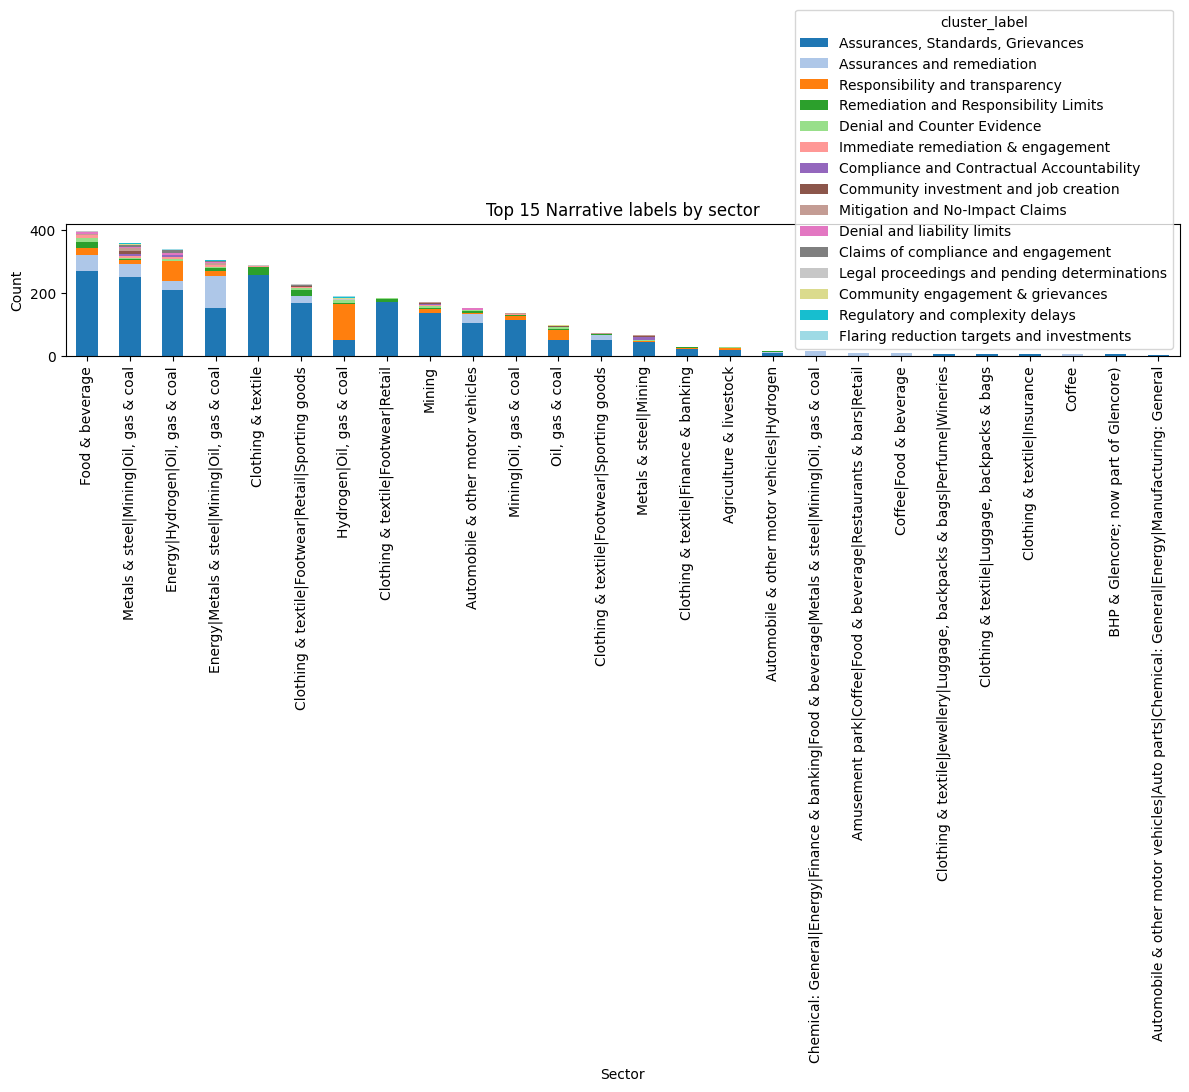

In [44]:
# Get top 15 labels by frequency
top15_labels = df['cluster_label'].value_counts().head(15).index.tolist()

# Filter pivot_sector to only top 15 labels (columns)
pivot_sector_top15 = pivot_sector[top15_labels]

plt.figure(figsize=(12, max(4, 0.35 * len(pivot_sector_top15))))
cmap = cm.get_cmap('tab20', len(top15_labels))
pivot_sector_top15.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca(),
    color=[cmap(i) for i in range(len(top15_labels))]
)

plt.title("Top 15 Narrative labels by sector")
plt.xlabel("Sector")
plt.ylabel("Count")
plt.tight_layout()
out_top15 = PLOTS_DIR / "top_15_labels_by_sector.png"
plt.savefig(out_top15, dpi=150)
print(f"Saved: {out_top15.resolve()}")
plt.show()
plt.close()

# Labels over time

Saved: C:\Users\bscherrer\Documents\snf-project3\plots\labels_over_time_yearly.png


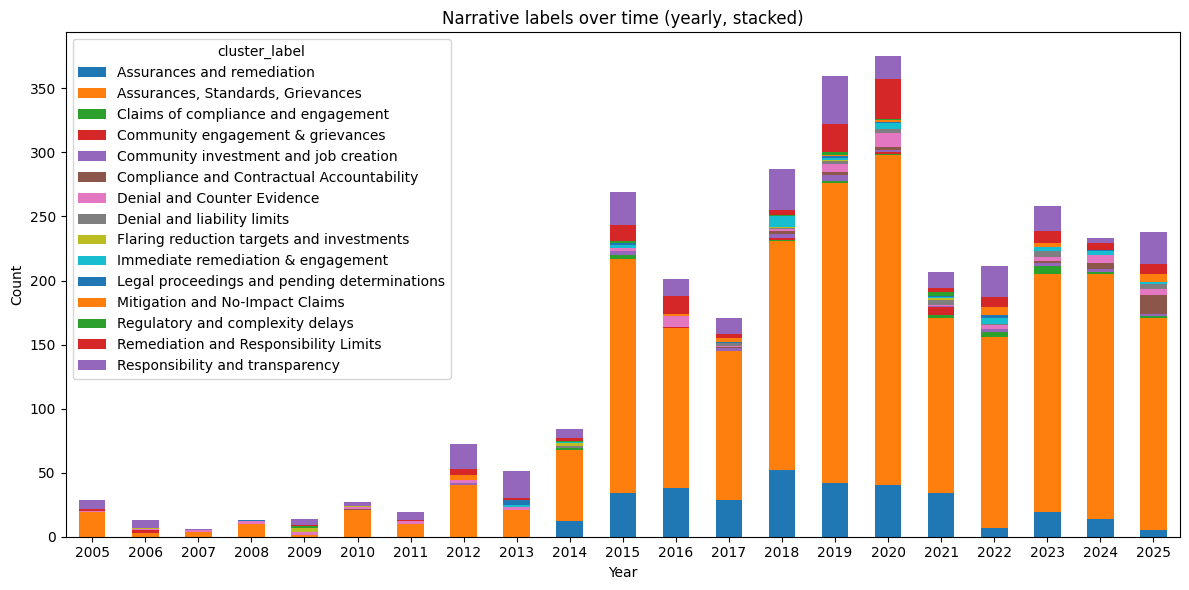

In [48]:
df_top15 = df[df['cluster_label'].isin(top15_labels)].copy()

df_time = df_top15.dropna(subset=["month"]).copy()
if df_time.empty:
    warnings.warn("No valid dates found; skipping time-based plots.")
else:
    # Extract year from the monthly period
    df_time["year"] = df_time["month"].dt.year
    counts_year = (
        df_time.groupby(["year", "cluster_label"])
        .size()
        .reset_index(name="n")
    )
    pivot_year = counts_year.pivot(index="year", columns="cluster_label", values="n").fillna(0)
    pivot_year = pivot_year.sort_index()    # Sort chronologically

    plt.figure(figsize=(12, 6))
    pivot_year.plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title("Narrative labels over time (yearly, stacked)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    out_year = PLOTS_DIR / "labels_over_time_yearly.png"
    plt.savefig(out_year, dpi=150)
    print(f"Saved: {out_year.resolve()}")
    plt.show()
    plt.close()


# Top 5 labels over time

C:\Users\bscherrer\AppData\Local\Temp\ipykernel_25872\1096112924.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



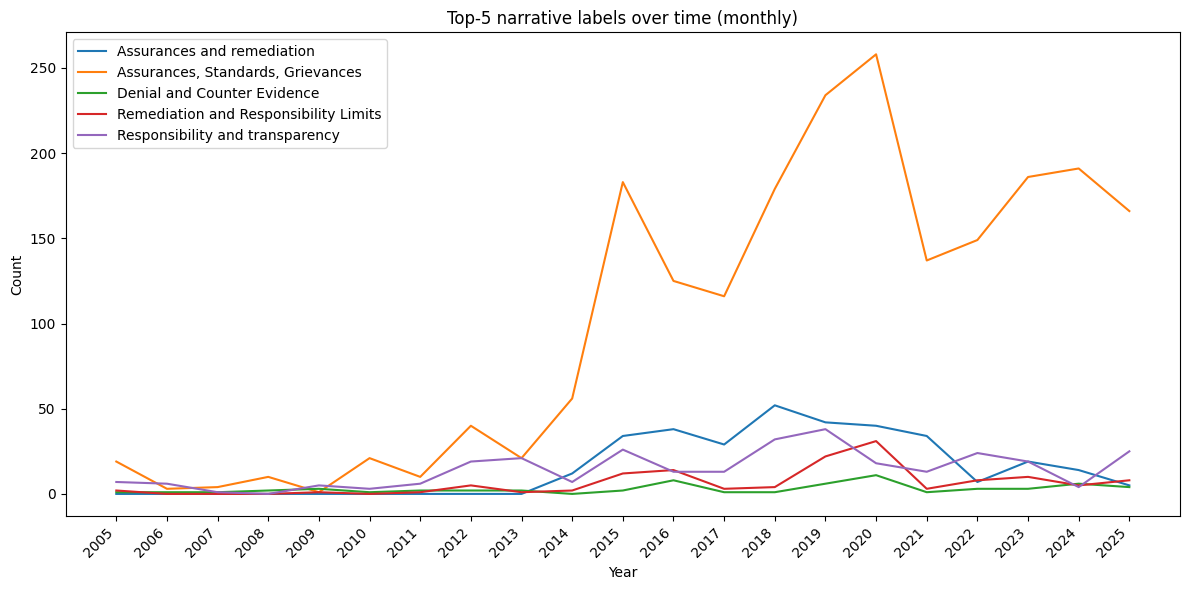

Saved: C:\Users\bscherrer\Documents\snf-project3\plots\labels_over_time_top5.png


In [52]:
# -------------------------
# Optional: Top-5 labels over time (line chart)
# -------------------------
total_by_label = counts_time.groupby("cluster_label")["n"].sum().sort_values(ascending=False)
top5 = total_by_label.head(5).index.tolist()

top5_time = counts_time[counts_time["cluster_label"].isin(top5)]
lines = top5_time.pivot(index="month_str", columns="cluster_label", values="n").fillna(0)
idx_periods = pd.PeriodIndex(lines.index, freq="M")
lines = lines.iloc[np.argsort(idx_periods.values)]
lines.index = lines.index.astype(str)

# Make sure 'year' column exists
if "year" not in top5_time.columns:
    # If not, extract year from month_str or from a date column
    if "month_str" in top5_time.columns:
        top5_time["year"] = top5_time["month_str"].str[:4].astype(int)
    elif "month" in top5_time.columns:
        top5_time["year"] = top5_time["month"].dt.year

# Group by year and cluster_label
lines_year = (
    top5_time.groupby(["year", "cluster_label"])["n"]
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)
lines_year.index = lines_year.index.astype(str) 

plt.figure(figsize=(12, 6))
for col in lines_year.columns:
    plt.plot(lines_year.index, lines_year[col], label=col)
plt.title("Top-5 narrative labels over time (monthly)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
out3 = PLOTS_DIR / "labels_over_time_top5.png"
plt.savefig(out3, dpi=150)
plt.show()
plt.close()
print(f"Saved: {out3.resolve()}")

# Sector x label table

In [57]:
# -----------------------------
# Optional: sector x label table (CSV)
# -----------------------------
heatmap_tbl = df.groupby(["Company Sectors", "cluster_label"]).size().unstack(fill_value=0)
heatmap_csv = PLOTS_DIR / "sector_label_table.csv"
heatmap_tbl.to_csv(heatmap_csv)
heatmap_tbl.head(5)

cluster_label,Assurances and remediation,"Assurances, Standards, Grievances",Authorization and secure deliveries,COVID travel disruption; supplier accountability,Claims of compliance and engagement,Community engagement & grievances,Community health outreach,Community investment and job creation,Compliance and Contractual Accountability,Compliance and cost‑shifting,...,"Military enforcement, fisherfolk unprepared",Mitigation and No-Impact Claims,Ongoing community communication,Regulatory and complexity delays,Regulatory recall compliance,Remediation and Responsibility Limits,Removal of problematic items,Responsibility and transparency,Timeline and status updates,Transparency: published impact assessment
Company Sectors,,,,,,,,,,,,,,,,,,,,,
BHP & Glencore; now part of Glencore),0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agriculture & livestock,0,20,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,6,0,0
Amusement park|Coffee|Food & beverage|Restaurants & bars|Retail,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Automobile & other motor vehicles,30,104,0,0,0,0,0,0,0,0,...,0,1,0,0,0,7,0,3,0,0
Automobile & other motor vehicles|Auto parts|Chemical: General|Energy|Manufacturing: General,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
